In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint


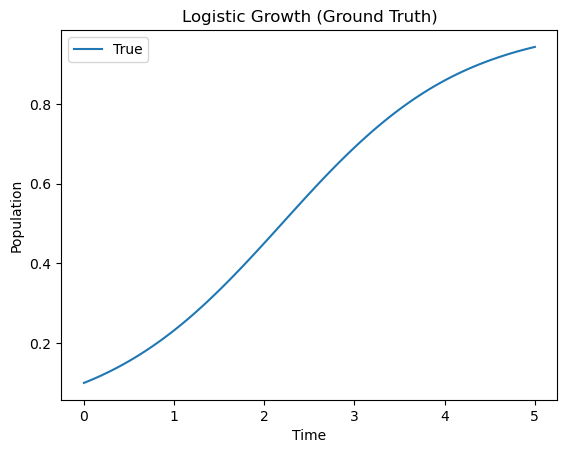

In [2]:
from scipy.integrate import solve_ivp

# Logistic growth dynamics
def logistic(t, y, r=1.0, K=1.0):
    return r * y * (1 - y / K)

# Time points and initial value
t_eval = np.linspace(0, 5, 100)
y0 = [0.1]

# Solve ODE
sol = solve_ivp(logistic, t_span=[0, 5], y0=y0, t_eval=t_eval)
t_true = sol.t
y_true = sol.y[0]

# Plot ground truth
plt.plot(t_true, y_true, label='True')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('Logistic Growth (Ground Truth)')
plt.show()


In [9]:
import torch

# Convert data to torch tensors
t_tensor = torch.tensor(t_true, dtype=torch.float32)
y_tensor = torch.tensor(y_true, dtype=torch.float32).unsqueeze(1)  # shape (100, 1)

import torch.nn as nn

class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t, y):
        return self.net(y)

from torchdiffeq import odeint

class NeuralODE(nn.Module):
    def __init__(self, ode_func):
        super().__init__()
        self.ode_func = ode_func

    def forward(self, y0, t):
        return odeint(self.ode_func, y0, t)




In [10]:
func = ODEFunc()
model = NeuralODE(func)

import torch.optim as optim

# Initial condition
y0 = y_tensor[0]  # shape (1,)

# Model, optimizer, loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(3000):
    optimizer.zero_grad()
    pred_y = model(y0, t_tensor)
    loss = loss_fn(pred_y, y_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')



Epoch 0, Loss: 0.020376
Epoch 100, Loss: 0.001130
Epoch 200, Loss: 0.001082
Epoch 300, Loss: 0.001020
Epoch 400, Loss: 0.000943
Epoch 500, Loss: 0.000847
Epoch 600, Loss: 0.000716
Epoch 700, Loss: 0.001124
Epoch 800, Loss: 0.000311
Epoch 900, Loss: 0.000152
Epoch 1000, Loss: 0.000082
Epoch 1100, Loss: 0.000047
Epoch 1200, Loss: 0.000031
Epoch 1300, Loss: 0.000216
Epoch 1400, Loss: 0.000036
Epoch 1500, Loss: 0.000281
Epoch 1600, Loss: 0.000007
Epoch 1700, Loss: 0.000021
Epoch 1800, Loss: 0.000090
Epoch 1900, Loss: 0.000005
Epoch 2000, Loss: 0.000021
Epoch 2100, Loss: 0.000302
Epoch 2200, Loss: 0.000005
Epoch 2300, Loss: 0.000060
Epoch 2400, Loss: 0.000252
Epoch 2500, Loss: 0.000007
Epoch 2600, Loss: 0.000008
Epoch 2700, Loss: 0.000005
Epoch 2800, Loss: 0.000174
Epoch 2900, Loss: 0.000005


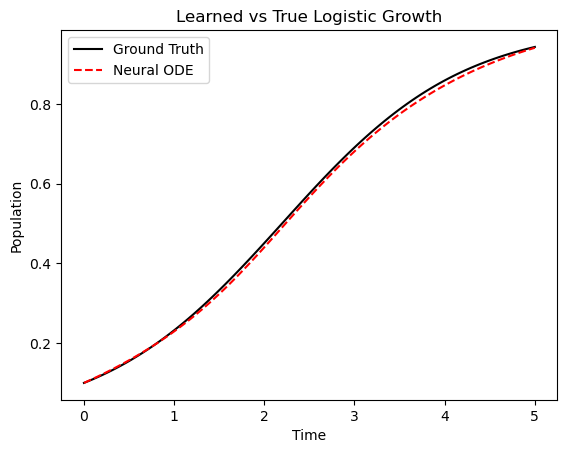

In [11]:

with torch.no_grad():
    pred_y = model(y0, t_tensor).squeeze().numpy()

# Plot
plt.plot(t_true, y_true, 'k-', label='Ground Truth')
plt.plot(t_true, pred_y, 'r--', label='Neural ODE')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Learned vs True Logistic Growth')
plt.legend()
plt.show()
